In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import pandas as pd
import data
from IPython.display import HTML, Markdown
# import myWidgets
import logisticRegression
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import Model
import Trackers.ModelTracker as ModelTracker
import plot_tools
import writing_tools
import FeatureTools
import Trackers.FeatureTracker as FeatureTracker
import Trackers.DataTracker as DataTracker
import math

In [3]:
df = data.get_data()
model_tracker = ModelTracker.ModelTracker()
#feature_tracker = FeatureTracker.FeatureTracker(df.copy())
data_tracker = DataTracker.X_tracker()
cols_to_scale = []

$$\text{logit } p = \ln \frac{p}{1-p} = \beta_0 + \beta_1x_1 + ... + \beta_nx_n = z$$
$$ e^z = \frac{p}{1-p} \iff p = \frac{e^z}{1 + e^z} $$
$$p = P(\text{CARAVAN} = 1 | X = x)$$

$$\text{odds } = \frac{p}{1-p}$$

$$OR = e^{\beta}$$

Le odds-ratio permet de mesurer l'effet d'une variable sur la probabilité qu'un évenements se produise (CARAVAN = 1).

Il faut que je calcul l'intervalle de confiance pour assumer qu'une variable est significative selon la valeur de son $OR$.

Pour calculer un intervalle de confiance, j'ai besoin de l'écart-type des variables. Mais puisque OR dépend des rélations entres les variables, je dois utiliser une matrice de covariance, qui est l'inverse de la matrice de Fisher Information.

**Fisher Information :** 

$$\theta = \mathbb{E} \left[ \left( \frac{\partial}{\partial \theta} \log f(X; \theta) \right)^2 \right]$$

$\mathbb{E} = $  espérance de $X$ \
$f(X; \theta) = $ fonction de densité de $X$

Forme matrice : 

$$p_i = P(\text{CARAVAN} = 1 | X_i) = \sigma(X_i \cdot \beta) = \dfrac{e^{X_i \cdot \beta}}{1 + e^{X_i \cdot \beta}} $$
$$\ell(\beta) = \sum^n_{i=1} \log f(X_i; \theta) =  \sum_{i=1}^{n} \Big[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \Big] = - \text{cost function }$$
$$(y_i = \text{la valeur observée du target (0 ou 1))}$$
$$
\frac{\partial \ell}{\partial \beta} = X^T (y - p) = \text{gradient ascent} \\
\frac{\partial^2 \ell}{\partial \beta\, \partial \beta^T} = -X^T W X = \text{variation du gradient ascent}
$$

$$\text y_i \sim Bernoulli(p) \iff Var(y_i) = p_i(1 - p_i)$$

$$ W = diag(p_i(1 - p_i)) = Var(Y) =
\begin{bmatrix}
p_1(1-p_1) & 0 & \cdots & 0 \\
0 & p_2(1-p_2) & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & p_n(1-p_n)
\end{bmatrix}$$

Sa calcul la précision de l'estimation d'un coefficient 


In [4]:
categorical_non_ordinales = ['MOSTYPE', 'MOSHOOFD']
df_encoded = pd.get_dummies(df, columns=categorical_non_ordinales, prefix=categorical_non_ordinales, dtype=int, drop_first=True)
X_base_one_hot = df_encoded.copy()
feature_tracker = FeatureTracker.FeatureTracker(X_base_one_hot)
X_train_np, y_train_np, X_val_np, y_val_np = feature_tracker.return_split_train_eval(toNpy=True)

model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[914 181]
 [ 33  37]]


In [5]:
coeff = model.w
bias = model.b
odds_ratio = np.exp(coeff)
confiance = 0.95

def fisher_info(X, w, b):
    z = X @ w + b
    p = logisticRegression.sigmoid(z)
    W = np.diag(p * (1-p))
    fi = X.T @ W @ X
    return fi

fi = fisher_info(X_train_np, coeff, bias)
print(np.linalg.det(fi))

4.753692681997185e-11


La matrice de covariance est proche d'être singuliaire, car $\text{det}(\text{fisher\_information}) \approx 0$, elle est presque non-inversible. \
Si je l'inverse, il y a des variances gigantesque et positive/négative.

- Si on regarde qu'elle variance $\lt$ 0, on trouve que 14 d'entres elles sont négatives (elles sont aussi gigantesques) $( Var(y) \lt -10^{14})$. \
29 sont des variables catégoriques non-ordinales à propos du type de cients et 2 sont à propos du nombre et la contribution d'assurance surfboard. \

- Si on regarde ceux qui sont géante, on trouve qu'il y en a 32 d'entres elles qui sont gigantesques.


C'est un signe que ces variables sont peut-être complètement séparer des données, donc pourait prédire constamment le même résultat, ce qui indique que leur $\beta$ tend vers $\pm \infin$.

In [6]:
cov_matrix = np.linalg.inv(fi)
#std = np.sqrt(np.diag(cov_matrix))
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'var': np.diag(cov_matrix),
})

print('négatif count in variance:               ', coef_df[coef_df['var'] < 0].shape[0])
print('négatif gigantesque count in variance:   ', coef_df[coef_df['var'] <= -10**13].shape[0])
print('Gigantesque count in variance:           ', coef_df[coef_df['var'] >= 10**(14)].shape[0])

huge_neg_coeff_cols = coef_df[coef_df['var'] < 0]['feature'].values
huge_pos_coeff_cols = coef_df[coef_df['var'] >= 10**(14)]['feature'].values

inf_coef_cols = np.concatenate((huge_neg_coeff_cols, huge_pos_coeff_cols), axis=0)
X_train_inf_coef = X_train[inf_coef_cols].copy()

négatif count in variance:                14
négatif gigantesque count in variance:    14
Gigantesque count in variance:            32


Si on vérifie, on trouve qu'il y a quelque une variable qui prédit toujours CARAVAN = 0 et le reste sont des cas très rares.

In [7]:
huge_neg_coeff_cols = coef_df[coef_df['var'] < 0]['feature'].values
huge_pos_coeff_cols = coef_df[coef_df['var'] >= 10**(14)]['feature'].values

inf_coef_cols = np.concatenate((huge_neg_coeff_cols, huge_pos_coeff_cols), axis=0)
X_train_inf_coef = X_train[inf_coef_cols].copy()

cols_with_zeros_targets = []
cols_with_all_targets = []
cols_with_rare_outcomes = {}

for c in inf_coef_cols:
    crossTab = pd.crosstab(X_train_inf_coef[c], y_train)

    if 1 in crossTab.index:
        #print(f'\n{c} = 1')
        not_target_count = crossTab.loc[1, 0]
        target_count = crossTab.loc[1, 1]
        #print(f"    (CARAVAN=0) : {not_target_count}")

        if target_count == 0:
            #print(f'    Prédit toujours CARAVAN=0')
            cols_with_zeros_targets.append(c)
        elif not_target_count == 0:
            #print(f'    Prédit toujours CARAVAN=1')
            cols_with_all_targets.append(c)
        else:
           #print(f"    (CARAVAN=1): {target_count}")
           cols_with_rare_outcomes[c] = np.array([target_count, not_target_count])
    else:
        print('what?')

Les variables qui prédisent tous le temps CARAVAN = 0 dans le training set sont inutiles donc je vais les retirer.

In [8]:
feature_tracker.remove_list(cols_with_zeros_targets)
X = feature_tracker.flush_to_df()

X_train_np, y_train_np, X_val_np, y_val_np = feature_tracker.return_split_train_eval(toNpy=True)
#model = Model.create_model(X_train_np, y_train_np, X_val_np, y_val_np, learning_rate=0.01, set_threshold_to=0.1)

Les autres variables ne sont pas complètement séparer, mais peut-etre souffre de multicolinéarité, ce qui serait la cause de leur variance gigantesque.

Précédemment, j'avais utilisé une matrice de corrélation pour trouver les corrélations entre variables, mais le problème est qu'elle évalue seulement la colinéarité entre deux variables. Pour ce problème, c'est mieux d'utiliser le VIF, car il permet d'analyser l'impact de tout les autres variables sur la variance d'un coefficient, ce qui est exactement ce que j'ai besoin pour trouver la cause de la variance énorme des variables restantes. 

$$VIF = \dfrac{1}{1-R^2}$$
$$
X_i = \beta_0 + \sum_{j \neq i}(\beta_j X_j) + \varepsilon_i \\
\hat{\beta} = (X^TX)^{-1}X^Ty 
$$
$$\varepsilon_i = X_i -\hat{X_i} \iff Var(\varepsilon_i) = Var(X_i) -Var(\hat{X_i})$$
$$\sum{\varepsilon_i} = \sum{(X_i -\hat{X_i})} = 0$$
$$
R^{2}_{i} = \frac{Var(\hat{X_i})}{Var(X_i)} = \frac{ Var({X_i}) - Var(\varepsilon_i)}{Var(X_i)} 
= 1 - \frac{Var(\varepsilon_i)}{Var({X_i})}
$$

In [9]:
def ols(X, y):
    w = np.linalg.lstsq(X, y, rcond=None)[0]
    return w

def regressionLineaire(X, y):
    w = ols(X, y)
    residual = y - X @ w
    return w, residual

def auxRegLin(X, eps, tol=1e-12):
    var_residual = np.sum(eps**2)
    xm = np.mean(X)
    var_X = np.sum((X - xm)**2)
    if var_X <= tol: return 0
    return (1 - var_residual/var_X)
    
def vif(X, cols):
    vif_res = {}
    for c in cols:
        X_i = X[c].to_numpy()
        X_hat_i = X.drop(c, axis=1).to_numpy()
        X_hat = np.column_stack([np.ones(len(X_i)), X_hat_i])
        w, residu = regressionLineaire(X_hat, X_i)
        R2 = auxRegLin(X_i, residu)
        vif = np.inf if np.isclose(1 - R2, 0) else 1 / (1 - R2)
        vif_res[c] = vif
    return pd.DataFrame.from_dict(vif_res, orient='index', columns=['VIF']).sort_values(by='VIF', ascending=False)

df_vif = vif(X.drop('CARAVAN', axis=1), cols_with_rare_outcomes)


In [10]:
index_mid_corr = df_vif[(df_vif['VIF'] > 1) & (df_vif['VIF'] <= 5)].index
index_high_corr = df_vif[(df_vif['VIF'] > 5) & (df_vif['VIF'] <= 10)].index
index_serious_corr = df_vif[(df_vif['VIF'] > 10)].index

Tout les variables avec un $R^2$ = $\inf$ (colinéarité parfaite, donc parfaitement prédite par les autres variables) sont des variables de types MOSTYPE (customer sub-type) ou MOSHOOFD (customer main type). Je vais les retirer puisqu'elle n'aide pas le modèle. Les seules que je vais garder sont eux avec 1 < VIF < 5. Plus grand leur résultat VIF indique qu'ils sont hautement corrélés.

Les métriques restent similaires à avant le retrait de ces variables, donc c'est une confirmation que le retrait n'a pas tellement affecté les prédictions du modèles.

In [11]:
feature_tracker.remove_list(index_high_corr)
feature_tracker.remove_list(index_serious_corr)

X = feature_tracker.flush_to_df()

model = feature_tracker.get_trained_model()

Threshold   : 0.1000
[[913 182]
 [ 33  37]]


Maintenant, on retourne au calcul de Fisher information pour trouver les variables les plus utiles pour prédire CARAVAN=1

In [12]:
X_train_np, y_train_np, X_val_np, y_val_np = feature_tracker.return_split_train_eval(toNpy=True)
fi = FeatureTools.fisher_info(X_train_np, model.w, model.b)
print(np.linalg.det(fi))

-1.615584458150003e+94


In [13]:
eigen_values = np.linalg.eigvals(fi)
print('Nombre de eigen values négative: ', (eigen_values<0).sum())

Nombre de eigen values négative:  1


In [14]:
eigen_values, eigen_vectors = np.linalg.eig(fi)
negative_values = (eigen_values<0)
idx_problem = [i for i, is_negative in enumerate(negative_values) if is_negative]

problematic_vector = eigen_vectors[:, idx_problem]

index = X.drop('CARAVAN', axis=1).columns

problematic_variables_df = pd.DataFrame(np.abs(problematic_vector), index=index)
Markdown(problematic_variables_df.sort_values(by=0, ascending=False).head().to_markdown())


|         |           0 |
|:--------|------------:|
| PZEILPL | 0.707107    |
| AZEILPL | 0.707107    |
| AVRAAUT | 5.81657e-15 |
| AGEZONG | 4.81223e-15 |
| AWAOREG | 2.64977e-15 |

Seulement une personne dans le training set a PZEILPL ou AZEILPL > 0 et CARAVAN = 1

In [15]:
Markdown(FeatureTools.get_target_count_of_variables(X_train, y_train, ['PZEILPL', 'AZEILPL']))


|    |   PZEILPL (CARAVAN=1) |   AZEILPL (CARAVAN=1) |
|---:|----------------------:|----------------------:|
|  0 |                   277 |                   277 |
|  1 |                     1 |                     1 |

Parfait, maintenant le determinant n'est plus négatif

In [16]:
feature_tracker.remove_list(['PZEILPL', 'AZEILPL'])
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model(print_stats=False)

X_train_np, y_train_np, X_val_np, y_val_np = feature_tracker.return_split_train_eval(toNpy=True)
fi = FeatureTools.fisher_info(X_train_np, model.w, model.b)
print(np.linalg.det(fi))

9.848675513629938e+128


In [17]:
import scipy.stats as st

coeff = model.w 
bias = model.b 
odds_ratio = np.exp(coeff) 
confiance = 0.95

X_train_np, y_train_np, X_val_np, y_val_np = feature_tracker.return_split_train_eval(toNpy=True)

fi = FeatureTools.fisher_info(X_train_np, model.w, model.b)
cov_matrix = np.linalg.inv(fi)
std = np.sqrt(np.diag(cov_matrix))

surface = 1 - (1-confiance)/2
z = st.norm.ppf(surface)

bi = coeff - z * std
bs = coeff + z * std

bi_or = np.exp(bi)
bs_or = np.exp(bs)
    
coef_df = pd.DataFrame({
    'feature': X.drop('CARAVAN', axis=1).columns,
    '$\\beta_n$': model.w,
    '$OR$': odds_ratio,
    '$bi_{OR}$': bi_or,
    '$bs_{OR}$': bs_or
})

coef_df = coef_df.round(4)

mask_signif = (coef_df['$bi_{OR}$'] > 1) | (coef_df['$bs_{OR}$'] < 1)
Markdown(coef_df[mask_signif].to_markdown())

|    | feature   |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:----------|------------:|-------:|------------:|------------:|
| 44 | PPERSAUT  |      0.1974 | 1.2182 |      1.1104 |      1.3365 |

$$OR > 1 \to \text{augmente les chances que CARAVAN = 1}$$
$$OR < 1 \to \text{diminue les chances que CARAVAN = 1}$$
$$OR = 1 \to \text{aucun effet sur les chances que CARAVAN = 1}$$

Présentement, voici à quoi ressemble le modèle sans aucune variable additionnel.

In [18]:
DATA_V1 = 'DATA_FE2_NO_ADDED_VARS_JUST_FILTERED_BASE'
X = feature_tracker.flush_to_df()
data_tracker.add(DATA_V1, X)

Dataset DATA_FE2_NO_ADDED_VARS_JUST_FILTERED_BASE saved.



In [19]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
cols = df_vif[df_vif['VIF'] >= 10].index
cols.sort_values()

Index(['AAANHANG', 'ABROM', 'ABYSTAND', 'AGEZONG', 'AMOTSCO', 'AVRAAUT',
       'AWALAND', 'AWAOREG', 'AWAPART', 'AWERKT', 'MAUT0', 'MAUT1', 'MFALLEEN',
       'MFGEKIND', 'MFWEKIND', 'MGODPR', 'MHHUUR', 'MHKOOP', 'MINK4575',
       'MINKM30', 'MOPLHOOG', 'MOPLLAAG', 'MOPLMIDD', 'MRELGE', 'MRELOV',
       'MSKC', 'MZFONDS', 'MZPART', 'PAANHANG', 'PBROM', 'PBYSTAND', 'PGEZONG',
       'PMOTSCO', 'PTRACTOR', 'PVRAAUT', 'PWALAND', 'PWAOREG', 'PWAPART'],
      dtype='object')

Tout les variables qui débute par A sont des variables qui indique le nombre de police d'assurance x.
Je vais tout les regrouper en une seule variable 'total' puisqu'elle mesure la meme chose que les variables P mais sous une différentes unité. (Nombre de polices vs Contribution). 

| Type d'assurance                          | Variables associées | Description complète |
|------------------------------------------|-------------------|--------------------|
| Assurance vie / accidents / santé         | ALEVEN, APERSONG, AGEZONG, AWAOREG, ABRAND, ABYSTAND | Number of life insurances, private accident insurance policies, family accidents insurance policies, disability insurance policies, fire policies, social security insurance policies |
| Third party insurance                     | AWAPART, AWABEDR, AWALAND | Private third party insurance, third party insurance (firms), third party insurance (agriculture) |
| Assurance véhicule quotidien              | APERSAUT, AMOTSCO, ABROM | Number of car policies, motorcycle/scooter policies, moped policies |
| Assurance véhicule de travail / poids lourd | AVRAAUT, ATRACTOR, AWERKT, AAANHANG, ABESAUT | Number of lorry, tractor, agricultural machines, trailer policies, delivery van policies |
| Assurance propriété                       | AINBOED           | Number of property insurance policies |
| Assurance véhicule de loisir              | APLEZIER, AFIETS, AZEILPL | Number of boat, bicycle, surfboard policies |





In [20]:
print('|----- Avant le regroupement -----|')
model = feature_tracker.get_trained_model()

|----- Avant le regroupement -----|
Threshold   : 0.1000
[[913 182]
 [ 33  37]]


In [21]:
feature_tracker.restore('AZEILPL') # car retirer précédemment
X = feature_tracker.flush_to_df()

life_accidents_health = np.array(['ALEVEN','APERSONG','AGEZONG','AWAOREG','ABRAND','ABYSTAND'])
third_party_insurance = np.array(['AWAPART','AWABEDR','AWALAND'])
daily_vehicle = np.array(['APERSAUT','AMOTSCO','ABROM'])
work_heavy_vehicle = np.array(['AVRAAUT','ATRACTOR','AWERKT','AAANHANG','ABESAUT'])
property_insurance = np.array(['AINBOED'])
leisure_vehicle = np.array(['APLEZIER','AFIETS','AZEILPL'])

all_policies = np.concatenate([life_accidents_health, third_party_insurance, daily_vehicle, work_heavy_vehicle, property_insurance, leisure_vehicle])

feature_tracker.add('total_policies', X[all_policies].sum(axis=1), toScale=True)
feature_tracker.remove_list(all_policies)
X = feature_tracker.flush_to_df()

print('|----- Après le regroupement -----|')
model = feature_tracker.get_trained_model()

|----- Après le regroupement -----|
Threshold   : 0.1000
[[914 181]
 [ 32  38]]


In [22]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
df_vif[df_vif['VIF'] >= 10]

,VIF
MHHUUR,1607.413278
MHKOOP,1605.011609
MZFONDS,802.201002
MZPART,801.486528
MOPLLAAG,31.976265
MRELGE,22.988768
MFWEKIND,21.727982
MRELOV,18.949109
MOPLMIDD,18.107363
MFALLEEN,15.636070


(Rented house) MHHUUR $\iff$ MHKOOP (Home owner) \
(National Health Service) MZFONDS $\iff$ MZPART (Private health insurance)

MOPLLAAG - MOPLMIDD - MOPLHOOG (retire une, devient catégorie de référence)

MRELGE - MRELOV - MRELSA (retire une, devient catégorie de référence) (MRELOV, car plus facile a interpreter apres, marier ou habite ensemble ou sinon catégorie de référence aka other relation)

MFWEKIND - MFGEKIND - MFALLEEN (meme chose que ^) (MFGEKIND)

MAUT0 - MAUT1 - MAUT2 (mm chose) (MAUT0)

MINK* (mm chose) (MINKM30)

MGOD* (mm chose) (MGODOV)

MBER* (mm chose) (MBERARBO)

In [23]:
feature_tracker.remove_list(['MHHUUR', 'MZFONDS', 'MOPLLAAG', 'MRELOV', 'MFGEKIND', 'MAUT0', 'MINKM30', 'MGODOV', 'MBERARBO'])
X = feature_tracker.flush_to_df()

In [24]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
Markdown(df_vif[df_vif['VIF'] >= 5].to_markdown())

|                |     VIF |
|:---------------|--------:|
| total_policies | 9.87819 |
| MSKA           | 8.15507 |
| MSKC           | 7.76223 |

Pour le reste des variables, je vais utiliser le score Z pour voir si elle sont significative ou pas.

$$H_0 : w_i = 0$$
$$H_1 : w_i \neq 0$$

In [25]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
model = feature_tracker.get_trained_model(print_stats=False)

Elles contiennent tous $0$, il y a la possibilité que l'effet de ces variables soit nul.

In [26]:
fi = FeatureTools.fisher_info(X_train.to_numpy(), model.w, model.b)
cov_matrix = np.linalg.inv(fi)
std = np.sqrt(np.diag(cov_matrix))

z_scores = model.w / std

z_scores_df = pd.DataFrame({
    'Variable': X_train.columns,
    '$w_i$': model.w,
    r'$\sigma$': std,
    '$Z$': abs(z_scores)
})

z_scores_df['$b_i$'] = z_scores_df['$w_i$'] - 1.96 * z_scores_df[r'$\sigma$']
z_scores_df['$b_s$'] = z_scores_df['$w_i$'] + 1.96 * z_scores_df[r'$\sigma$']

vars = ['total_policies', 'MSKA', 'MSKC']

Markdown(z_scores_df[z_scores_df['Variable'].isin(vars)].to_markdown())

|    | Variable       |      $w_i$ |   $\sigma$ |      $Z$ |     $b_i$ |     $b_s$ |
|---:|:---------------|-----------:|-----------:|---------:|----------:|----------:|
| 17 | MSKA           | -0.0337001 |  0.0982806 | 0.342896 | -0.22633  | 0.15893   |
| 20 | MSKC           | -0.109832  |  0.0758362 | 1.44828  | -0.258471 | 0.0388066 |
| 60 | total_policies |  0.102733  |  0.169785  | 0.605078 | -0.230046 | 0.435512  |

Le coefficient de la variable PFIETS de total_policies est le plus élevé. Un client avec une assurance vélo a tendance à avoir beaucoup plus de polices au total.

In [27]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols, return_coef=True)
Markdown(df_vif[df_vif['Target'] == 'total_policies'].sort_values(by='coef', key=abs, ascending=False).head().to_markdown())

|      | Target         | Variable   |      coef |
|-----:|:---------------|:-----------|----------:|
| 3660 | total_policies | Intercept  | -1.21704  |
| 3710 | total_policies | PFIETS     |  0.882518 |
| 3700 | total_policies | PAANHANG   |  0.517393 |
| 3693 | total_policies | PWAPART    |  0.410282 |
| 3702 | total_policies | PWERKT     |  0.388062 |

Mais dans le training set, seulement 11/278 $\approx$ 3.96% des targets ont une contribution plus grande que 0 pour PFIETS (Contribution bicycle policies).

In [28]:
X_train[y_train == 1][['PFIETS']].value_counts().sort_index()

PFIETS
0         267
1          11
Name: count, dtype: int64

In [29]:
vars = ['total_policies', 'MSKA', 'MSKC']
feature_tracker.remove_list(vars)
X = feature_tracker.flush_to_df()

X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 5].to_markdown())

| VIF   |
|-------|


Les variables significatives sont 

In [30]:
model = feature_tracker.get_trained_model(print_stats=False)
Markdown(FeatureTools.or_with_ic(model, X_train.to_numpy(), X_train.columns))

|    | feature   |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:----------|------------:|-------:|------------:|------------:|
| 33 | PPERSAUT  |      0.1848 | 1.203  |      1.1456 |      1.2633 |
| 45 | PBRAND    |      0.0925 | 1.0969 |      1.0076 |      1.194  |
| 16 | MBERARBG  |     -0.1017 | 0.9033 |      0.8182 |      0.9973 |
|  4 | MGODPR    |     -0.1219 | 0.8852 |      0.7894 |      0.9928 |
|  8 | MFALLEEN  |     -0.1654 | 0.8476 |      0.7584 |      0.9472 |
|  5 | MGODGE    |     -0.1766 | 0.8382 |      0.7456 |      0.9423 |

Au lieu d'utiliser total_policies, je vais voir si des total thématiques sont mieux. total_policies était trop corrélée.

In [31]:
print('|----- Sans ajout -----|')
model = feature_tracker.get_trained_model()

|----- Sans ajout -----|
Threshold   : 0.1000
[[926 169]
 [ 33  37]]


In [32]:
feature_tracker.restore('AZEILPL') # car retirer précédemment

life_accidents_health = np.array(['ALEVEN','APERSONG','AGEZONG','AWAOREG','ABRAND','ABYSTAND'])
third_party_insurance = np.array(['AWAPART','AWABEDR','AWALAND'])
daily_vehicle = np.array(['APERSAUT','AMOTSCO','ABROM'])
work_heavy_vehicle = np.array(['AVRAAUT','ATRACTOR','AWERKT','AAANHANG','ABESAUT'])
property_insurance = np.array(['AINBOED'])
leisure_vehicle = np.array(['APLEZIER','AFIETS','AZEILPL'])

all_policies = np.concatenate([life_accidents_health, third_party_insurance, daily_vehicle, work_heavy_vehicle, property_insurance, leisure_vehicle])
feature_tracker.restore_list(all_policies)
X = feature_tracker.flush_to_df()

feature_tracker.add('total_life_health_policies', X[life_accidents_health].sum(axis=1), toScale=True)
feature_tracker.add('total_third_party_policies', X[third_party_insurance].sum(axis=1), toScale=True)
feature_tracker.add('total_daily_vehicle_policies', X[daily_vehicle].sum(axis=1), toScale=True)
feature_tracker.add('total_work_heavy_vehicle_policies', X[work_heavy_vehicle].sum(axis=1), toScale=True)
feature_tracker.add('total_property_policies', X[property_insurance].sum(axis=1), toScale=True)
feature_tracker.add('total_leisure_vehicle_policies', X[leisure_vehicle].sum(axis=1), toScale=True)

feature_tracker.remove_list(all_policies)
X = feature_tracker.flush_to_df()

print('|----- Après le regroupement -----|')
model = feature_tracker.get_trained_model()

|----- Après le regroupement -----|
Threshold   : 0.1000
[[923 172]
 [ 32  38]]


In [33]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 5].to_markdown())

|                                   |      VIF |
|:----------------------------------|---------:|
| total_third_party_policies        | 20.7014  |
| PWAPART                           | 19.619   |
| total_work_heavy_vehicle_policies | 11.0279  |
| total_leisure_vehicle_policies    |  7.39488 |
| total_daily_vehicle_policies      |  7.33684 |
| PFIETS                            |  6.49889 |
| PPERSAUT                          |  6.20111 |
| total_life_health_policies        |  5.21299 |


In [34]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval(to_scale=False)

total_vars = [
    'total_third_party_policies',
    'PWAPART'
]

Markdown(FeatureTools.get_target_count_of_variables(X_train, y_train, total_vars))

|    |   total_third_party_policies (CARAVAN=1) |   PWAPART (CARAVAN=1) |
|---:|-----------------------------------------:|----------------------:|
|  0 |                                      116 |                   120 |
|  1 |                                      162 |                     6 |
|  2 |                                        0 |                   150 |
|  3 |                                        0 |                     2 |

Si total_third_party_policies == 1, alors PWAPART est majoritairement 2. 
- $\frac{150}{162} \approx 0.926$

Si total_third_party_policies == 0, alors PWAPART est majoritairement 0. 
- $\frac{116}{116} = 1$

PWAPART prédit déja majoritairement total_third_party_policies et cela fais du sens puisque PWAPART = Contribution private third party insurance. Donc je vais retirer total_third_party_policies puisqu'elle est redondante.

In [35]:
print(X_train.loc[(y_train == 1) & (X_train['total_third_party_policies'] == 0 ),'PWAPART'].value_counts())

print(X_train.loc[(y_train == 1) & (X_train['total_third_party_policies'] == 1 ),'PWAPART'].value_counts())

PWAPART
0    116
Name: count, dtype: int64
PWAPART
2    150
1      6
0      4
3      2
Name: count, dtype: int64


In [36]:
feature_tracker.remove('total_third_party_policies')
X = feature_tracker.flush_to_df()

In [37]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval(to_scale=False)

total_vars = [
    'total_life_health_policies',
    'total_daily_vehicle_policies',
    'total_work_heavy_vehicle_policies',
    'total_leisure_vehicle_policies'
]

Markdown(FeatureTools.get_target_count_of_variables(X_train, y_train, total_vars))

|    |   total_life_health_policies (CARAVAN=1) |   total_daily_vehicle_policies (CARAVAN=1) |   total_work_heavy_vehicle_policies (CARAVAN=1) |   total_leisure_vehicle_policies (CARAVAN=1) |
|---:|-----------------------------------------:|-------------------------------------------:|------------------------------------------------:|---------------------------------------------:|
|  0 |                                       87 |                                         61 |                                             269 |                                          255 |
|  1 |                                      153 |                                        174 |                                               8 |                                           17 |
|  2 |                                       24 |                                         39 |                                               1 |                                            5 |
|  3 |                                        8 |                                          3 |                                               0 |                                            1 |
|  4 |                                        3 |                                          1 |                                               0 |                                            0 |
|  5 |                                        3 |                                          0 |                                               0 |                                            0 |

Seulement trois targets dans le training set ont une police de propriété. Je vais la jumeler a total_life_health_policies pour former total_life_policies.

Similairement pour total_work_heavy_vehicle_policies, seulement 9 des targets ont au moins une police de cette catégorie. Pareil pour total_leisure_vehicle_policies, seulement 23 sur 278. Je vais fusionner total_work_heavy_vehicle_policies à total_daily_vehicle_policies et total_leisure_vehicle_policies pour former total_vehicle_policies.



In [38]:
X_train.loc[y_train == 1, 'total_property_policies'].value_counts()

total_property_policies
0    275
1      3
Name: count, dtype: int64

In [39]:
feature_tracker.add('total_life_policies', X['total_property_policies'] + X['total_life_health_policies'], toScale=True)
feature_tracker.add('total_vehicle_policies', X['total_work_heavy_vehicle_policies'] + X['total_daily_vehicle_policies'] + X['total_leisure_vehicle_policies'], toScale=True)
feature_tracker.remove_list(['total_property_policies', 'total_life_health_policies', 'total_work_heavy_vehicle_policies', 'total_daily_vehicle_policies', 'total_leisure_vehicle_policies'])
X = feature_tracker.flush_to_df()

In [40]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 5].to_markdown())

|                        |     VIF |
|:-----------------------|--------:|
| total_vehicle_policies | 8.80815 |
| total_life_policies    | 5.22103 |
| PPERSAUT               | 5.00302 |


Finalement, elles sont tous redondantes...

In [41]:
feature_tracker.remove_list(['total_life_policies', 'total_vehicle_policies'])
X = feature_tracker.flush_to_df()

In [42]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
model = feature_tracker.get_trained_model(print_stats=False)
Markdown(FeatureTools.or_with_ic(model, X_train.to_numpy(), X_train.columns))

|    | feature   |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:----------|------------:|-------:|------------:|------------:|
| 33 | PPERSAUT  |      0.1848 | 1.203  |      1.1456 |      1.2633 |
| 45 | PBRAND    |      0.0925 | 1.0969 |      1.0076 |      1.194  |
| 16 | MBERARBG  |     -0.1017 | 0.9033 |      0.8182 |      0.9973 |
|  4 | MGODPR    |     -0.1219 | 0.8852 |      0.7894 |      0.9928 |
|  8 | MFALLEEN  |     -0.1654 | 0.8476 |      0.7584 |      0.9472 |
|  5 | MGODGE    |     -0.1766 | 0.8382 |      0.7456 |      0.9423 |

In [43]:
model = feature_tracker.get_trained_model(set_threshold_to=0.1)

Threshold   : 0.1000
[[926 169]
 [ 33  37]]


Maintenant que le modèle est simplifier, je vais commencer a ajouter des nouvelles variables.

En testant des combinaisons différentes j'ai trouver ceci : si au lieu d'utiliser MINKM30 comme catégorie de référence j'utilise MINKM3045. Je garde le VIF de tout les variables en bas de 5 et MINKM30 devient une variable significative avec un OR < 1.

|    | feature   |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:----------|------------:|-------:|------------:|------------:|
| 53 | MINKM30   |     -0.1384 | 0.8707 |      0.7908 |      0.9587 |

In [44]:
income_vars = [
    'MINKM30',
    #'MINK3045',
    'MINK4575',
    'MINK7512',
    'MINK123M',
    'MINKGEM'
]

feature_tracker.remove('avg_area_income')
feature_tracker.restore_list(income_vars)
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model(print_stats=False)

X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()

Markdown(FeatureTools.or_with_ic(model, X_train.to_numpy(), X_train.columns))

|    | feature   |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:----------|------------:|-------:|------------:|------------:|
| 33 | PPERSAUT  |      0.1895 | 1.2087 |      1.1502 |      1.2701 |
| 45 | PBRAND    |      0.0955 | 1.1002 |      1.01   |      1.1985 |
|  5 | MGODGE    |     -0.144  | 0.8659 |      0.7621 |      0.9837 |
| 58 | MINKM30   |     -0.1612 | 0.8511 |      0.7305 |      0.9916 |

In [45]:
feature_tracker.restore('MINKM30')
feature_tracker.restore('MINK3045')
X = feature_tracker.flush_to_df()

income_brackets_midpoints = {
    'MINKM30': 15000,    
    'MINK3045': 37500,   
    'MINK4575': 60000,   
    'MINK7512': 98500,   
    'MINK123M': 180000 
}

income_cols = list(income_brackets_midpoints.keys())
weighted_somme = 0
for col in income_cols:
    weighted_somme += X[col] * income_brackets_midpoints[col]
total = X[income_cols].sum(axis=1)

for c in income_cols:
    feature_tracker.remove(c)
feature_tracker.remove('MINKGEM')

feature_tracker.add('avg_area_income',  weighted_somme / total, toScale=True)

X = feature_tracker.flush_to_df()

In [46]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
Markdown(df_vif[df_vif['VIF'] >= 5].to_markdown())

| VIF   |
|-------|

In [47]:
model = feature_tracker.get_trained_model(print_stats=False)
Markdown(FeatureTools.or_with_ic(model, X_train.to_numpy(), X_train.columns))

|    | feature   |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:----------|------------:|-------:|------------:|------------:|
| 28 | PPERSAUT  |      0.1829 | 1.2007 |      1.1436 |      1.2607 |
| 40 | PBRAND    |      0.0912 | 1.0955 |      1.0063 |      1.1925 |
| 16 | MBERARBG  |     -0.1041 | 0.9012 |      0.8162 |      0.995  |
|  4 | MGODPR    |     -0.1271 | 0.8806 |      0.7848 |      0.9882 |
|  8 | MFALLEEN  |     -0.1623 | 0.8502 |      0.7597 |      0.9515 |
|  5 | MGODGE    |     -0.1825 | 0.8332 |      0.7417 |      0.9359 |

Maintenant concernant la variable MINKM30 (income < 30,000). On peut voir que quelqu'un qui habite dans un endroit avec bas income est moins probable d'avoir une assurance Caravan.

$$P(\text{avg\_area\_income} < 30000 \mid \text{CARAVAN} = 1) \approx 0.0312$$

In [48]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval(to_scale=False)
df_train = X_train.copy()
df_train['CARAVAN'] = y_train.copy()

print(df_train.loc[df_train['avg_area_income'] < 30000, 'CARAVAN'].mean().round(4))

0.0312


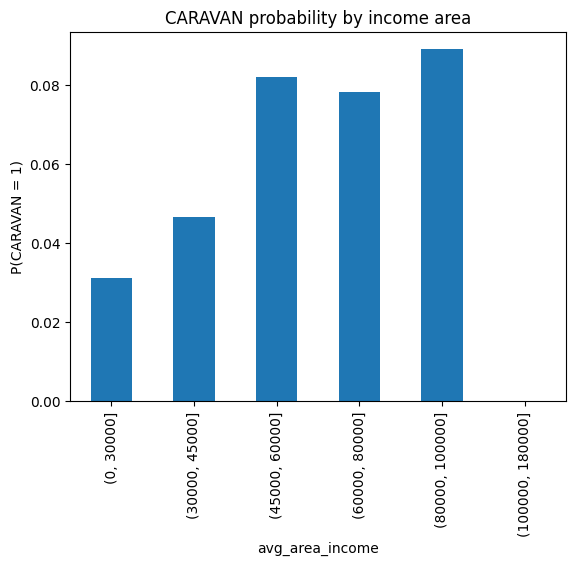

In [49]:
bins = [0, 30000, 45000, 60000, 80000, 100000, 180000]
df_income_bins = pd.DataFrame({
    'income_bin': pd.cut(X_train['avg_area_income'], bins=bins),
    'CARAVAN': y_train
})

rate_bin = df_income_bins.groupby('income_bin', observed=True)['CARAVAN'].mean()

ax = rate_bin.plot(kind='bar')
ax.set_xlabel("avg_area_income")
ax.set_ylabel("P(CARAVAN = 1)")
ax.set_title("CARAVAN probability by income area");

In [50]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()

features_significatifs = [
    "PPERSAUT",
    "PBRAND",
    "MBERARBG",
    "MGODPR",
    "MFALLEEN",
    "MGODGE"
]

other_vars = ['avg_area_income']

X_train_sel = X_train[features_significatifs]
X_val_sel = X_val[features_significatifs]

print('|----- Avec tout les variables (VIF < 5) -----|')
model = feature_tracker.get_trained_model()
print()

print('|----- Seulement les variables significatives -----|')
model = Model.create_model(X_train_sel, y_train, X_val_sel, y_val, learning_rate=0.01, set_threshold_to=0.1)
model.print_stats(X_val_sel, y_val)

|----- Avec tout les variables (VIF < 5) -----|
Threshold   : 0.1000
[[913 182]
 [ 33  37]]

|----- Seulement les variables significatives -----|
AUC         : 0.7330
Precision   : 0.1527
Recall      : 0.4429
F1          : 0.2271
Threshold   : 0.1000
[[923 172]
 [ 39  31]]


En regardant la projection PCA des FN et TP seulement, on voit une séparation selon PC2.

Les TP (bleus) sont vers le haut (PC2>2), tandis que les FN (oranges) reste en bas (PC2<0).

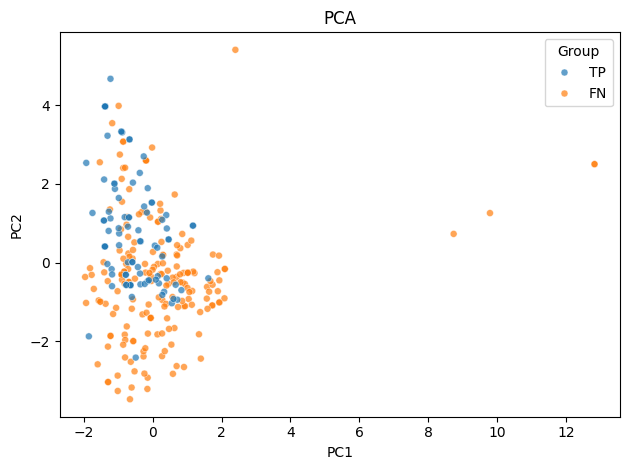

In [51]:
features_significatifs = [
    "PPERSAUT",
    "PBRAND",
    "MBERARBG",
    "MGODPR",
    "MFALLEEN",
    "MGODGE"
]

df_profiles = FeatureTools.get_df_model_analysis(X_train_sel, y_train, model.w, model.b, threshold=0.1, raw=True)

df_plot = df_profiles[df_profiles["Group"].isin(["TP","FN"])].copy()

X = pd.get_dummies(df_plot[features_significatifs].astype("category"), drop_first=False)

X_scaled = StandardScaler(with_mean=False).fit_transform(X) 
pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X_scaled)

loadings = pd.DataFrame(
    pca.components_.T, 
    index=X.columns,    
    columns=["PC1", "PC2"]
)

df_emb = pd.DataFrame(Z, columns=["PC1", "PC2"], index=df_plot.index)
df_emb["Group"] = df_plot["Group"].values

sns.scatterplot(data=df_emb, x="PC1", y="PC2", hue="Group", hue_order=["TP", "FN"], alpha=0.7, s=25)
plt.title("PCA")
plt.tight_layout()

In [52]:
important_PC2 = loadings["PC2"].abs().sort_values(ascending=False).head(6)
important_PC2

MGODGE_0      0.362739
PPERSAUT_6    0.322566
PPERSAUT_0    0.291635
MFALLEEN_0    0.286369
MGODPR_7      0.264550
MBERARBG_0    0.261186
Name: PC2, dtype: float64

Environ 30% des TP ont un MGODGE (No religion) de 0 ou 1, donc une absence quasi totale de personne religieuse dans leur quartier. En comparaison, seulement 9% des FN se trouvent dans cette section.

Environ 40% des FN ont un MGODGE (No religion) de 4 ou 5 vs environ 17% des TP. Le modele semble se dire que si MGODGE est élevé, alors non-acheteurs. MGODGE à 6 et 7 contient aucun acheteur selon le modèle. 

In [53]:
Markdown(df_plot.groupby("Group")["MGODGE"].value_counts(normalize=True).unstack().to_markdown())

| Group   |         0 |         1 |        2 |        3 |         4 |         5 |           6 |          7 |
|:--------|----------:|----------:|---------:|---------:|----------:|----------:|------------:|-----------:|
| FN      | 0.0638298 | 0.0319149 | 0.164894 | 0.255319 | 0.244681  | 0.180851  |   0.0212766 |   0.037234 |
| TP      | 0.188889  | 0.133333  | 0.233333 | 0.266667 | 0.0888889 | 0.0888889 | nan         | nan        |

Selon, le $OR$ de MGODGE, on peut voir que chaque augmentation à MGODGE, réduit la probabilité d'avoir une assurance CARAVAN d'environ 17%, ce qui est asser gros

|    | feature   |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:----------|------------:|-------:|------------:|------------:|
|  5 | MGODGE    |     -0.1825 | 0.8332 |      0.7417 |      0.9359 |

Pour réduire ce préjugés, je vais créer des variables binaire pour remplacer MGODGE avec objectif de ne plus rejeter quelqu'un, car il habite dans un quartier un peu trop religieux.

is_low_no_religion_area = MGODGE $\in [0,1,2]$


| Variables | Confusion Matrix | Δ FP (%) | Δ TP (%) |
|----------|------------------|----------|----------|
| MGODGE | $\begin{bmatrix} 913 & 182 \\ 33 & 37 \end{bmatrix}$ | 0% | 0% |
| is_low_no_religion_area | $\begin{bmatrix} 932 & 163 \\ 36 & 34 \end{bmatrix}$ | **−10.4%** | **−8.1%** |

La perte en TP est beaucoup trop grande comparer à la perte en FP. Séparer en variable low et mid donne des résultats similaires. Cette variable ne vaut pas la peine la perte en TP est trop importante.


Je vais analyser de plus près les TP et FN.

In [54]:
X = feature_tracker.flush_to_df()
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
X_train_unscaled, *_ = feature_tracker.return_split_train_eval(to_scale=False)

model = feature_tracker.get_trained_model(print_stats=False)
df_profiles = FeatureTools.get_df_model_analysis(X_train, y_train, model.w, model.b, threshold=0.1, raw=True)

df_tp = df_profiles[df_profiles["Group"] == "TP"].copy()
df_fn = df_profiles[df_profiles["Group"] == "FN"].copy()

La contribution d'un paramètre dans une regression logistique est $\beta_i x_i$. Alors pour comparer quel parametres distingue les TP vs FN. Je peux comparer les différences des contribution.

$$\Delta_i = \mathbb{E}(\beta_i x_i|TP) - \mathbb{E}(\beta_i x_i|FN)$$

Plus en plus la différence est grande, plus en plus un paramètre contribue à la décision de si c'est un TP ou FN.

In [55]:
contrib = df_profiles[X.drop('CARAVAN', axis=1).columns].mul(model.w, axis=1)
diff = contrib[df_profiles['Group'] == 'TP'].mean() - contrib[df_profiles['Group'] == 'FN'].mean()
diff.sort_values(key=abs, ascending=False).head()

PPERSAUT    0.413667
MGODGE      0.140490
MFALLEEN    0.136635
MBERARBG    0.121819
PBRAND      0.118089
dtype: float64

PPERSAUT est le paremètre principal qui décide si c'est un TP ou FN.

Je vais focus sur les FN count à PPERSAUT == 6, car la grande majorité des TP sont des PPERSAUT = 6. Je crois que sa serait plus facile de les changer à TP puisqu'ils ont la même valeur sur la variable dominante.

In [56]:
tab_tp = df_tp['PPERSAUT'].value_counts().rename('TP count')
tab_fn = df_fn['PPERSAUT'].value_counts().rename('FN count')
tab = pd.concat([tab_tp, tab_fn], axis=1).astype(int).rename_axis('PPERSAUT').reset_index()
total_row = pd.DataFrame([{
    'PPERSAUT': 'Total',
    'TP count': tab['TP count'].sum(),
    'FN count': tab['FN count'].sum()
}])

tab = pd.concat([tab, total_row], ignore_index=True)

Markdown(tab.to_markdown(index=False))

| PPERSAUT   |   TP count |   FN count |
|:-----------|-----------:|-----------:|
| 6.0        |        114 |         91 |
| 5.0        |          3 |          8 |
| 0.0        |          1 |         61 |
| Total      |        118 |        160 |

Maintenant si on focus sur les $(TP \cap PPERSAUT = 6)$ & $(FN \cap PPERSAUT = 6)$. 

Le paramètres principal est MFALLEEN (Singles).

In [57]:
df_tp_ppersaut_6 = df_tp[df_tp['PPERSAUT'] == 6].copy()
df_fn_ppersaut_6 = df_fn[df_fn['PPERSAUT'] == 6].copy()
diff = contrib.loc[df_tp_ppersaut_6.index].mean() - contrib.loc[df_fn_ppersaut_6.index].mean()
diff.sort_values(key=abs, ascending=False).head()

MFALLEEN    0.194032
MGODGE      0.177950
MBERARBG    0.131553
MHKOOP      0.124223
PBRAND      0.112406
dtype: float64

Les deux contributions sont négatives, donc MFALLEEN pénalise les deux, mais pénalise beaucoup plus les FN que les TP.
- Les TP avec PPERSAUT = 6 ont des valeurs MFALLEEN moins défavorable.
- Mais les FN avec PPERSAUT = 6 sont davantage pénalisés par MFALLEEN. 
- Il y a deux mode pour les MFALLEEN chez les FN, 0 et 3. 
    - Ceux avec une valeur de 0 ne sont pas pénalisé par MFALLEEN, mais ceux avec une valeur de 3, oui. 
    - Eux avec une valeur de 0 sont probablement pénalisés par d'autres variables.

In [58]:
tab = pd.DataFrame({
    'Group': ['TP (PPERSAUT = 6)', 'FN (PPERSAUT = 6)'],
    'Contribution moyenne (MFALLEEN)': [
        contrib.loc[df_tp_ppersaut_6.index, 'MFALLEEN'].mean(),
        contrib.loc[df_fn_ppersaut_6.index, 'MFALLEEN'].mean()
    ],
    'Mode (MFALLEEN)': [
        df_tp_ppersaut_6['MFALLEEN'].mode().tolist(),
        df_fn_ppersaut_6['MFALLEEN'].mode().tolist()
    ]})
Markdown(tab.to_markdown(index=False))

| Group             |   Contribution moyenne (MFALLEEN) | Mode (MFALLEEN)   |
|:------------------|----------------------------------:|:------------------|
| TP (PPERSAUT = 6) |                         -0.175075 | [0.0]             |
| FN (PPERSAUT = 6) |                         -0.369107 | [0.0, 3.0]        |

Pour réduire l'effet de cette variable, je vais multiplier MFALLEEN par PPERSAUT.

Presque tout les TP ont PPERSAUT = 6 et une partie importante des FN aussi. En créant cette variable, l'effet de MFALLEEN dépend de la valeur de PPERSAUT. Donc avec cette variable, l'effet de MFALLEEN sera réduit ou annuler si PPERSAUT est élevé. 

$$\begin{aligned}
z &= w_1 ​x_1 ​+ w_2 ​x_2 ​+ w_3 ​(x_1​x_2​)+b \\
\frac{\partial z}{\partial x_1} &= w_1 + w_3x_2
\end{aligned}$$

Exemple : \
$x_2 = 6$ \
$w_1 = -0.4$ \
$w_3 = 0.1$ 

$$\frac{\partial z}{\partial x_1} = -0.4 + 0.1 \cdot  6 = 0.2$$

Un gain de +3 TP pour seulement +7 FP! C'est bien!

In [59]:
print('|----- Avant la variable PPERSAUTxMFALLEEN -----|')
feature_tracker.remove('PPERSAUTxMFALLEEN')
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model()

print('\n|----- Après la variable PPERSAUTxMFALLEEN -----|')
feature_tracker.add('PPERSAUTxMFALLEEN', X['PPERSAUT']*X['MFALLEEN'])
X = feature_tracker.flush_to_df()
model = feature_tracker.get_trained_model()

|----- Avant la variable PPERSAUTxMFALLEEN -----|
Threshold   : 0.1000
[[913 182]
 [ 33  37]]

|----- Après la variable PPERSAUTxMFALLEEN -----|
Threshold   : 0.1000
[[906 189]
 [ 30  40]]


Mais, j'ai remarquer que les sur le training set, le modèle trouve moins de TP avec la variable PPERSAUTxMFALLEEN. Il était probablement entrain de overfit avant et maintenant que cette variable a été introduit, il est devenu plus générale sur ses prédictions

In [60]:
print('|----- Avant la variable PPERSAUTxMFALLEEN -----|')
feature_tracker.remove('PPERSAUTxMFALLEEN')
tab = FeatureTools.get_df_conf_matrix_count_by_var('PPERSAUT', feature_tracker)
display(Markdown(tab.to_markdown(index=False)))

print('|----- Après la variable PPERSAUTxMFALLEEN -----|')
feature_tracker.restore('PPERSAUTxMFALLEEN')
tab = FeatureTools.get_df_conf_matrix_count_by_var('PPERSAUT', feature_tracker)
display(Markdown(tab.to_markdown(index=False)))


|----- Avant la variable PPERSAUTxMFALLEEN -----|


| PPERSAUT   |   TP count |   FN count |
|:-----------|-----------:|-----------:|
| 6.0        |        114 |         91 |
| 5.0        |          3 |          8 |
| 0.0        |          1 |         61 |
| Total      |        118 |        160 |

|----- Après la variable PPERSAUTxMFALLEEN -----|


| PPERSAUT   |   TP count |   FN count |
|:-----------|-----------:|-----------:|
| 6.0        |        112 |         93 |
| 5.0        |          3 |          8 |
| 0.0        |          1 |         61 |
| Total      |        116 |        162 |

MGODGE est le prochain paramètre principale.

In [61]:
X_train, y_train, *_ = feature_tracker.return_split_train_eval()
df_profiles = FeatureTools.get_df_model_analysis(X_train, y_train, model.w, model.b, threshold=0.1, raw=True)
contrib = FeatureTools.get_df_conf_matrix_contrib(feature_tracker, model)
diff = contrib[df_profiles['Group'] == 'TP'].mean() - contrib[df_profiles['Group'] == 'FN'].mean()
diff.sort_values(key=abs, ascending=False).head()

PPERSAUT    0.362761
MGODGE      0.146309
MBERARBG    0.132641
PBRAND      0.120269
MFALLEEN    0.107290
dtype: float64

In [62]:
df_tn, df_fp, df_fn, df_tp = FeatureTools.get_df_conf_matrix_split(feature_tracker, model)

df_tp_ppersaut_6 = df_tp[df_tp['PPERSAUT'] == 6].copy()
df_fn_ppersaut_6 = df_fn[df_fn['PPERSAUT'] == 6].copy()

diff = contrib.loc[df_tp_ppersaut_6.index].mean() - contrib.loc[df_fn_ppersaut_6.index].mean()
diff.sort_values(key=abs, ascending=False).head()

MGODGE      0.183779
MFALLEEN    0.155048
MBERARBG    0.144524
MHKOOP      0.137227
PBRAND      0.115077
dtype: float64

Pareil, içi que MFALLEEN. Les deux contributions sont négatives, donc MGODGE pénalise les deux, mais pénalise beaucoup plus les FN que les TP.

In [63]:
tab = FeatureTools.get_df_conf_matrix_contrib_analysis('PPERSAUT', 6, 'MGODGE', feature_tracker, model)
Markdown(tab.to_markdown(index=False)) 

| Group             |   Contribution moyenne (MGODGE) | Mode (MGODGE)   |
|:------------------|--------------------------------:|:----------------|
| TP (PPERSAUT = 6) |                       -0.479229 | [2.0, 3.0]      |
| FN (PPERSAUT = 6) |                       -0.663008 | [5.0]           |

J'ai tester plusieurs variables différentes dont PPERSAUTxis_low_no_religion, PPERSAUTxis_high_no_religion, PPERSAUTxMGODGE, les résultats était majoritairement moins bon ou la différence n'était pas worth it (seulement -1 FP). Ces tests inclus la variable MGODGE seul dans chacun d'entre eux. La retirer donne des pires résultats dans tout les cas. L'interaction n'est pas assez ciblée pour faire une différence.

|                       | Base | is_high_no_religion_area | is_low_no_religion_area | PPERSAUT × MGODGE | PPERSAUT × is_high_no_religion_area | PPERSAUT × is_low_no_religion_area |
|-----------------------|------|--------------------------|-------------------------|-------------------|-------------------------------------|------------------------------------|
| Confusion Matrix | $\begin{bmatrix} 906 & 189 \\ 30 & 40 \end{bmatrix}$ | $\begin{bmatrix} 904 & 191 \\ 30 & 40 \end{bmatrix}$ | $\begin{bmatrix} 907 & 188 \\ 30 & 40 \end{bmatrix}$ | $\begin{bmatrix} 904 & 191 \\ 31 & 39 \end{bmatrix}$ | $\begin{bmatrix} 907 & 188 \\ 31 & 39 \end{bmatrix}$ | $\begin{bmatrix} 907 & 188 \\ 30 & 40 \end{bmatrix}$ |
| $\Delta$ vs Base | — | $\begin{bmatrix} -2 & +2 \\ 0 & 0 \end{bmatrix}$ | $\begin{bmatrix} +1 & -1 \\ 0 & 0 \end{bmatrix}$ | $\begin{bmatrix} -2 & +2 \\ +1 & -1 \end{bmatrix}$ | $\begin{bmatrix} +1 & -1 \\ +1 & -1 \end{bmatrix}$ | $\begin{bmatrix} +1 & -1 \\ 0 & 0 \end{bmatrix}$ |



In [64]:
X = feature_tracker.flush_to_df()
feature_tracker.add('is_high_no_religion_area', (X['MGODGE'] >= 4).astype(int))
feature_tracker.add('is_low_no_religion_area', (X['MGODGE'] <= 3).astype(int))
feature_tracker.add('PPERSAUTxMGODGE', X['PPERSAUT']*X['MGODGE'])

X = feature_tracker.flush_to_df()

feature_tracker.add('PPERSAUTxis_high_no_religion_area', X['PPERSAUT']*X['is_high_no_religion_area'])
feature_tracker.add('PPERSAUTxis_low_no_religion_area', X['PPERSAUT']*X['is_low_no_religion_area'])

vars_to_test = ['is_high_no_religion_area', 'is_low_no_religion_area', 'PPERSAUTxMGODGE', 'PPERSAUTxis_high_no_religion_area', 'PPERSAUTxis_low_no_religion_area']
feature_tracker.remove_list(vars_to_test)
X = feature_tracker.flush_to_df()

feature_tracker.feature_comparator(X, baseExtraCols=['MGODGE'], colsToTest=vars_to_test, set_threshold_to=0.1, print_metrics=False)

--------------------| Test avec les variables de base |--------------------
Threshold   : 0.1000
[[906 189]
 [ 30  40]]

|----- Test avec la variable is_high_no_religion_area -----|
Threshold   : 0.1000
[[904 191]
 [ 30  40]]

|----- Test avec la variable is_low_no_religion_area -----|
Threshold   : 0.1000
[[907 188]
 [ 30  40]]

|----- Test avec la variable PPERSAUTxMGODGE -----|
Threshold   : 0.1000
[[904 191]
 [ 31  39]]

|----- Test avec la variable PPERSAUTxis_high_no_religion_area -----|
Threshold   : 0.1000
[[907 188]
 [ 31  39]]

|----- Test avec la variable PPERSAUTxis_low_no_religion_area -----|
Threshold   : 0.1000
[[907 188]
 [ 30  40]]



In [65]:
X_train, y_train, X_val, y_val = feature_tracker.return_split_train_eval()
cols = X_train.columns

df_vif = FeatureTools.vif(X_train, cols)
print(df_vif[df_vif['VIF'] >= 5].to_markdown())

| VIF   |
|-------|


In [66]:
model = feature_tracker.get_trained_model()
print(FeatureTools.or_with_ic(model, X_train.to_numpy(), X_train.columns))

Threshold   : 0.1000
[[906 189]
 [ 30  40]]
|    | feature   |   $\beta_n$ |   $OR$ |   $bi_{OR}$ |   $bs_{OR}$ |
|---:|:----------|------------:|-------:|------------:|------------:|
| 28 | PPERSAUT  |      0.1626 | 1.1766 |      1.1016 |      1.2567 |
| 40 | PBRAND    |      0.0905 | 1.0947 |      1.0057 |      1.1916 |
| 16 | MBERARBG  |     -0.1059 | 0.8995 |      0.8148 |      0.9931 |
|  4 | MGODPR    |     -0.1298 | 0.8783 |      0.7827 |      0.9855 |
|  5 | MGODGE    |     -0.1857 | 0.8305 |      0.7394 |      0.9328 |
|  8 | MFALLEEN  |     -0.1908 | 0.8263 |      0.7008 |      0.9743 |
